We use CleanRL's DQN code to train our OneCar.

### Importing the needed libraries

In [ ]:
!pip install gymnasium

In [ ]:
!pip install wandb -qU
import wandb
wandb.login()

In [ ]:
!pip install stable-baselines3

### Basic setup

In [2]:
## Standard imports
import time, random
import numpy as np
from dataclasses import dataclass

# From: https://github.com/pygame/pygame/issues/2403
import os
if "XDG_RUNTIME_DIR" not in os.environ:
    os.environ["XDG_RUNTIME_DIR"] = "/tmp/runtime-root"

## Import Gym
import gymnasium as gym
from gymnasium.wrappers import FrameStack, GrayScaleObservation
from gymnasium.wrappers import TransformObservation, ResizeObservation
from gymnasium.wrappers import RecordVideo, RecordEpisodeStatistics

## PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
print("Using torch", torch.__version__)

## StableBaselines
from stable_baselines3.common.buffers import ReplayBuffer

Using torch 2.2.1+cu121


### Main code

#### Set up the environment

In [3]:
from OneCar_v3 import OneCarEnv

# Register custom environment with gym
gym.register(
    id="OneCar-v0",
    entry_point=OneCarEnv,
    reward_threshold=None
)

# Uncomment the below code to see if there are any warnings
# while instantiating an instance of our environment
# env = gym.make('OneCar-v0', render_mode='rgb_array')
# observation, info = env.reset()
# del env, observation, info

In [4]:
def make_env(env_id, seed, idx, capture_video, run_name, **kwargs):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array", **kwargs)
            env = RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)

        env = RecordEpisodeStatistics(env)
        env = ResizeObservation(env, shape=84)
        env = GrayScaleObservation(env)
        # env = TransformObservation(env, f=lambda x: x/255.)
        env = FrameStack(env, num_stack=4)

        env.action_space.seed(seed)
        return env

    return thunk

#### Set up hparams

In [5]:
@dataclass
class Args:
    exp_name = 'OneCar_DQN'  # Name of the experiment
    seed = 42867294  # Seed of the experiment
    torch_deterministic = True
    cuda = True  # Run on GPU if available

    track = True  # Tracked with W&B
    wandb_project_name = 'onecar_dqn'
    wandb_entity = None
    capture_video = True  # Take videos of agent's performance in `videos` folder
    save_model = True  # Save model into the `runs/{run_name}` folder

    ################# Algorithm specific arguments
    env_id = 'OneCar-v0'
    total_timesteps = 200000  # Should be `int` (7M steps)
    learning_rate = 1e-4
    num_envs = 1  # number of parallel game environments

    buffer_size = 40000  # Should be `int` and less than 500K
    gamma = 0.99  # Discount factor
    tau = 1.0  # Target network update rule
    target_network_sync = 1000  # Timesteps between target network sync
    batch_size = 32  # Batch size of sample from the replay memory

    start_eps = 1.0  # Starting eps for exploration
    end_eps = 0.01
    exploration_frac = 0.50  # Fraction of `total_timesteps` to go from start_eps to end_eps
    learning_starts = 25000  # Timestep after which learning starts
    train_freq = 4  # Number of steps between updates to policy network

#### Initialize the agent

In [6]:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x / 255.0)

In [7]:
# Define decay schedule for epsilon
def linear_schedule(start_eps, end_eps, duration, t):
    slope = (end_eps - start_eps) / duration
    return max(slope * t + start_eps, end_eps)

#### Actual training

In [ ]:
##########################################
######### Set up W&B, logging ############
##########################################

args = Args()
assert args.num_envs == 1, "vectorized envs are not supported at the moment"
run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"

if args.track:
    wandb.init(
        project=args.wandb_project_name,  # Project name
        entity=args.wandb_entity,
        sync_tensorboard=True,
        config=vars(args),  # Hyperparams. and run metadata
        name=run_name,  # Pass a run name
        monitor_gym=True,
        save_code=True,
    )

writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

In [9]:
##########################################
########### Set up the seeds #############
##########################################
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

In [10]:
##########################################
######## Set up the environment ##########
##########################################
envs = gym.vector.SyncVectorEnv(
    [make_env(args.env_id, args.seed + i, i,
              args.capture_video, run_name,
              continuous=False) for i in range(args.num_envs)]
)
assert isinstance(envs.single_action_space,
                  gym.spaces.Discrete), "Only discrete action space is supported"

In [11]:
##########################################
###### Set up DQN and ReplayBuffer #######
##########################################
q_network = QNetwork(envs).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate)

target_network = QNetwork(envs).to(device)
target_network.load_state_dict(q_network.state_dict())

rb = ReplayBuffer(
    args.buffer_size,  # 20000
    envs.single_observation_space,
    envs.single_action_space,
    device,
    args.num_envs,
    optimize_memory_usage=True,
    handle_timeout_termination=False,
)

In [12]:
# Total memory usage (in GB) by our replay buffer
(rb.observations.nbytes + rb.actions.nbytes + rb.rewards.nbytes + rb.dones.nbytes)/1e9

1.1296

We now start the game...

In [13]:
mse_loss = nn.MSELoss()  # See SO 72706218
start_time = time.time()
obs, _ = envs.reset(seed=args.seed)

for global_step in range(args.total_timesteps):
    # STEP 1: Take an action according to eps-greedy policy
    epsilon = linear_schedule(args.start_eps, args.end_eps,
                              args.exploration_frac * args.total_timesteps,
                              global_step)
    if random.random() < epsilon:
        actions = np.array([envs.single_action_space.sample() for _ in range(
            envs.num_envs)])
    else:
        q_values = q_network(torch.Tensor(obs).to(device))
        actions = torch.argmax(q_values, dim=1).cpu().numpy()

    # STEP 2: Perform the action and log the data.
    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    # STEP 3: Record rewards for plotting purposes
    if "final_info" in infos:
        for info in infos["final_info"]:
            if info and "episode" in info:
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)

    # STEP 4: Save data to replay buffer; handle `final_observation`
    real_next_obs = next_obs.copy()
    for idx, trunc in enumerate(truncations):
        if trunc:
            real_next_obs[idx] = infos["final_observation"][idx]
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    # STEP 5
    obs = next_obs

    # STEP 6: Training
    if global_step > args.learning_starts:  # after 40000 steps
        if global_step % args.train_freq == 0:  # multiples of 4
            # STEP 6a: Sample from memory
            data = rb.sample(args.batch_size)

            with torch.no_grad():  # STEP 6b: Get TD target
                target_max, _ = target_network(data.next_observations).max(dim=1)
                td_target = data.rewards.flatten() + args.gamma * target_max * (1 - data.dones.flatten())
            # STEP 6c: Get TD estimate and calculate loss
            old_val = q_network(data.observations).gather(1, data.actions).squeeze()
            loss = mse_loss(td_target, old_val)

            if global_step % 100 == 0:
                writer.add_scalar("losses/td_loss", loss, global_step)
                writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                # number of steps per second
                print("SPS:", int(global_step / (time.time() - start_time)))
                writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

            # STEP 6d: Optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # STEP 6e: Update target network
        if global_step % args.target_network_sync == 0:  # multiples of 1000
            for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
                target_network_param.data.copy_(
                    args.tau * q_network_param.data + (1.0 - args.tau) * target_network_param.data
                )

elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Moviepy - Building video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-0.mp4.
Moviepy - Writing video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-0.mp4
global_step=27, episodic_return=[0.]


Moviepy - Building video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-1.mp4.
Moviepy - Writing video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-1.mp4
global_step=68, episodic_return=[1.]
global_step=119, episodic_return=[1.]
global_step=170, episodic_return=[2.]


global_step=225, episodic_return=[2.]
global_step=268, episodic_return=[2.]
global_step=324, episodic_return=[0.]
global_step=352, episodic_return=[0.]
Moviepy - Building video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-8.mp4.
Moviepy - Writing video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-8.mp4
global_step=380, episodic_return=[0.]


global_step=430, episodic_return=[2.]
global_step=475, episodic_return=[1.]
global_step=548, episodic_return=[4.]
global_step=616, episodic_return=[3.]
global_step=644, episodic_return=[0.]
global_step=672, episodic_return=[0.]
global_step=711, episodic_return=[1.]
global_step=739, episodic_return=[0.]
global_step=777, episodic_return=[1.]
global_step=818, episodic_return=[1.]
global_step=848, episodic_return=[1.]
global_step=923, episodic_return=[1.]
global_step=981, episodic_return=[1.]
global_step=1009, episodic_return=[0.]
global_step=1039, episodic_return=[0.]
global_step=1082, episodic_return=[1.]
global_step=1110, episodic_return=[0.]
global_step=1140, episodic_return=[1.]
Moviepy - Building video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-27.mp4.
Moviepy - Writing video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-27.mp4
global_step=1168, episodic_return=[0.]
global_step=1196, episodic_return=[0.]
global_step=1239, episodic_return=[1.]
global_step=1279, episodic_return=[1.]
global_step=1331, episodic_return=[1.]
global_step=1397, episodic_return=[3.]
global_step=1456, episodic_return=[1.]
global_step=1493, episodic_return=[1.]
global_step=1534, episodic_return=[1.]
global_step=1562, episodic_return=[0.]
global_step=1590, episodic_return=[0.]
global_step=1618, episodic_return=[0.]
global_step=1647, episodic_return=[0.]
global_step=1676, episodic_return=[0.]
global_step=1704, episodic_return=[0.]
global_step=1734, episodic_return=[0.]
global_step=1763, episodic_return=[0.]
global_step=1793, episodic_return=[0.]
global_step=1836, episodic_return=[0.]
global_step=1864, episodic_return=[0.]
global_step=1894, episodic_return=[0.]
global_step=1933, episodic_return=[1

Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-64.mp4
global_step=2561, episodic_return=[0.]


global_step=2626, episodic_return=[3.]
global_step=2654, episodic_return=[0.]
global_step=2682, episodic_return=[0.]
global_step=2712, episodic_return=[1.]
global_step=2740, episodic_return=[0.]
global_step=2770, episodic_return=[1.]
global_step=2798, episodic_return=[0.]
global_step=2826, episodic_return=[0.]
global_step=2879, episodic_return=[1.]
global_step=2926, episodic_return=[2.]
global_step=2956, episodic_return=[1.]
global_step=2986, episodic_return=[0.]
global_step=3031, episodic_return=[0.]
global_step=3061, episodic_return=[0.]
global_step=3091, episodic_return=[0.]
global_step=3139, episodic_return=[1.]
global_step=3169, episodic_return=[0.]
global_step=3262, episodic_return=[2.]
global_step=3290, episodic_return=[0.]
global_step=3318, episodic_return=[0.]
global_step=3348, episodic_return=[0.]
global_step=3378, episodic_return=[0.]
global_step=3429, episodic_return=[3.]
global_step=3458, episodic_return=[0.]
global_step=3487, episodic_return=[0.]
global_step=3529, episodi

Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-125.mp4
global_step=4995, episodic_return=[0.]
global_step=5058, episodic_return=[3.]
global_step=5101, episodic_return=[1.]
global_step=5129, episodic_return=[0.]


global_step=5159, episodic_return=[0.]
global_step=5189, episodic_return=[0.]
global_step=5218, episodic_return=[0.]
global_step=5301, episodic_return=[4.]
global_step=5331, episodic_return=[1.]
global_step=5359, episodic_return=[0.]
global_step=5388, episodic_return=[0.]
global_step=5443, episodic_return=[1.]
global_step=5472, episodic_return=[0.]
global_step=5500, episodic_return=[0.]
global_step=5528, episodic_return=[0.]
global_step=5583, episodic_return=[1.]
global_step=5612, episodic_return=[0.]
global_step=5640, episodic_return=[0.]
global_step=5670, episodic_return=[0.]
global_step=5698, episodic_return=[0.]
global_step=5727, episodic_return=[0.]
global_step=5757, episodic_return=[0.]
global_step=5787, episodic_return=[0.]
global_step=5829, episodic_return=[2.]
global_step=5868, episodic_return=[1.]
global_step=5929, episodic_return=[3.]
global_step=5974, episodic_return=[1.]
global_step=6004, episodic_return=[1.]
global_step=6032, episodic_return=[0.]
global_step=6060, episodi

Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-216.mp4
global_step=8308, episodic_return=[0.]


global_step=8375, episodic_return=[3.]
global_step=8405, episodic_return=[0.]
global_step=8434, episodic_return=[0.]
global_step=8477, episodic_return=[0.]
global_step=8507, episodic_return=[1.]
global_step=8558, episodic_return=[2.]
global_step=8601, episodic_return=[1.]
global_step=8642, episodic_return=[1.]
global_step=8686, episodic_return=[1.]
global_step=8715, episodic_return=[0.]
global_step=8744, episodic_return=[0.]
global_step=8789, episodic_return=[1.]
global_step=8831, episodic_return=[2.]
global_step=8905, episodic_return=[1.]
global_step=8933, episodic_return=[0.]
global_step=8963, episodic_return=[0.]
global_step=9063, episodic_return=[4.]
global_step=9107, episodic_return=[0.]
global_step=9137, episodic_return=[0.]
global_step=9165, episodic_return=[0.]
global_step=9193, episodic_return=[0.]
global_step=9272, episodic_return=[2.]
global_step=9300, episodic_return=[0.]
global_step=9344, episodic_return=[0.]
global_step=9372, episodic_return=[0.]
global_step=9400, episodi

Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-343.mp4
global_step=13087, episodic_return=[0.]
global_step=13127, episodic_return=[0.]
global_step=13157, episodic_return=[0.]
global_step=13215, episodic_return=[0.]


global_step=13243, episodic_return=[0.]
global_step=13273, episodic_return=[1.]
global_step=13334, episodic_return=[2.]
global_step=13375, episodic_return=[1.]
global_step=13403, episodic_return=[0.]
global_step=13446, episodic_return=[1.]
global_step=13499, episodic_return=[0.]
global_step=13563, episodic_return=[3.]
global_step=13592, episodic_return=[0.]
global_step=13622, episodic_return=[0.]
global_step=13651, episodic_return=[0.]
global_step=13691, episodic_return=[0.]
global_step=13719, episodic_return=[0.]
global_step=13749, episodic_return=[0.]
global_step=13833, episodic_return=[5.]
global_step=13873, episodic_return=[1.]
global_step=13912, episodic_return=[2.]
global_step=13942, episodic_return=[0.]
global_step=13970, episodic_return=[0.]
global_step=14008, episodic_return=[0.]
global_step=14065, episodic_return=[2.]
global_step=14093, episodic_return=[0.]
global_step=14121, episodic_return=[0.]
global_step=14165, episodic_return=[0.]
global_step=14205, episodic_return=[1.]


Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-512.mp4
global_step=19498, episodic_return=[1.]
global_step=19526, episodic_return=[0.]
global_step=19567, episodic_return=[1.]


global_step=19634, episodic_return=[3.]
global_step=19663, episodic_return=[0.]
global_step=19708, episodic_return=[1.]
global_step=19736, episodic_return=[0.]
global_step=19841, episodic_return=[3.]
global_step=19894, episodic_return=[2.]
global_step=19924, episodic_return=[0.]
global_step=19954, episodic_return=[0.]
global_step=19983, episodic_return=[0.]
global_step=20011, episodic_return=[0.]
global_step=20049, episodic_return=[1.]
global_step=20078, episodic_return=[0.]
global_step=20106, episodic_return=[0.]
global_step=20148, episodic_return=[1.]
global_step=20178, episodic_return=[0.]
global_step=20207, episodic_return=[0.]
global_step=20246, episodic_return=[0.]
global_step=20274, episodic_return=[0.]
global_step=20313, episodic_return=[2.]
global_step=20341, episodic_return=[0.]
global_step=20389, episodic_return=[1.]
global_step=20427, episodic_return=[1.]
global_step=20455, episodic_return=[0.]
global_step=20484, episodic_return=[0.]
global_step=20512, episodic_return=[0.]


Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-729.mp4
global_step=27635, episodic_return=[0.]


global_step=27663, episodic_return=[0.]
global_step=27691, episodic_return=[0.]
SPS: 828
global_step=27721, episodic_return=[0.]
global_step=27749, episodic_return=[0.]
global_step=27779, episodic_return=[0.]
SPS: 827
global_step=27809, episodic_return=[0.]
global_step=27837, episodic_return=[0.]
global_step=27866, episodic_return=[0.]
SPS: 825
global_step=27924, episodic_return=[2.]
global_step=27992, episodic_return=[2.]
SPS: 824
global_step=28030, episodic_return=[1.]
global_step=28069, episodic_return=[1.]
SPS: 823
global_step=28108, episodic_return=[0.]
global_step=28168, episodic_return=[3.]
SPS: 822
global_step=28254, episodic_return=[2.]
global_step=28282, episodic_return=[0.]
SPS: 820
global_step=28312, episodic_return=[1.]
global_step=28350, episodic_return=[0.]
SPS: 819
global_step=28407, episodic_return=[1.]
global_step=28448, episodic_return=[0.]
global_step=28476, episodic_return=[0.]
SPS: 818
global_step=28504, episodic_return=[0.]
global_step=28534, episodic_return=[0.]

Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224/rl-video-episode-1000.mp4
global_step=39274, episodic_return=[2.]
SPS: 726
global_step=39304, episodic_return=[0.]


global_step=39373, episodic_return=[2.]
SPS: 726
global_step=39401, episodic_return=[0.]
global_step=39429, episodic_return=[0.]
global_step=39488, episodic_return=[2.]
SPS: 725
global_step=39564, episodic_return=[2.]
global_step=39592, episodic_return=[0.]
SPS: 725
SPS: 724
global_step=39711, episodic_return=[3.]
global_step=39741, episodic_return=[0.]
global_step=39799, episodic_return=[2.]
SPS: 724
SPS: 723
global_step=39950, episodic_return=[6.]
global_step=39980, episodic_return=[1.]
SPS: 723
global_step=40008, episodic_return=[0.]
global_step=40038, episodic_return=[0.]
SPS: 722
global_step=40101, episodic_return=[2.]
SPS: 721
global_step=40204, episodic_return=[5.]
global_step=40233, episodic_return=[0.]
global_step=40261, episodic_return=[0.]
SPS: 721
global_step=40333, episodic_return=[2.]
global_step=40362, episodic_return=[0.]
global_step=40399, episodic_return=[1.]
SPS: 720
global_step=40451, episodic_return=[0.]
global_step=40499, episodic_return=[1.]
SPS: 720
global_step=

In [ ]:
## RUN THIS only when you don't want to save the model
# envs.close()

#### Save the final model

In [16]:
# Evaluate the model

def evaluate(model_path, make_env, env_id, eval_episodes,
             run_name, Model, device, epsilon, capture_video=True):
    """
    """
    envs = gym.vector.SyncVectorEnv(
        [make_env(env_id, 0, 0, capture_video, run_name,
                  continuous=False)]
    )
    model = Model(envs).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    obs, _ = envs.reset()
    episodic_returns = []

    while len(episodic_returns) < eval_episodes:
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            q_values = model(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()
        next_obs, _, _, _, infos = envs.step(actions)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if "episode" not in info:
                    continue
                print(f"eval_episode={len(episodic_returns)}, episodic_return={info['episode']['r']}")
                episodic_returns += [info["episode"]["r"]]
        obs = next_obs
    return episodic_returns

In [17]:
if args.save_model:
    model_path = f"runs/{run_name}/{args.exp_name}"
    torch.save(q_network.state_dict(), model_path)
    print(f"model saved to {model_path}")

    # Get the episodic returns
    episodic_returns = evaluate(
        model_path,
        make_env,
        args.env_id,
        eval_episodes=15,
        run_name=f"{run_name}-eval",
        Model=QNetwork,
        device=device,
        epsilon=0.05,
    )
    for idx, episodic_return in enumerate(episodic_returns):
        writer.add_scalar("eval/episodic_return", episodic_return, idx)

envs.close()
writer.close()
wandb.finish()

model saved to runs/OneCar-v0__OneCar_DQN__42867294__1714799224/OneCar_DQN
Moviepy - Building video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224-eval/rl-video-episode-0.mp4.
Moviepy - Writing video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224-eval/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224-eval/rl-video-episode-0.mp4
eval_episode=0, episodic_return=[8.]
Moviepy - Building video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224-eval/rl-video-episode-1.mp4.
Moviepy - Writing video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224-eval/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224-eval/rl-video-episode-1.mp4
eval_episode=1, episodic_return=[5.]
eval_episode=2, episodic_return=[7.]
eval_episode=3, episodic_return=[28.]
eval_episode=4, episodic_return=[1.]
eval_episode=5, episodic_return=[7.]
eval_episode=6, episodic_return=[7.]
eval_episode=7, episodic_return=[3.]
Moviepy - Building video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224-eval/rl-video-episode-8.mp4.
Moviepy - Writing video /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224-eval/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /teamspace/studios/this_studio/videos/OneCar-v0__OneCar_DQN__42867294__1714799224-eval/rl-video-episode-8.mp4
eval_episode=8, episodic_return=[11.]
eval_episode=9, episodic_return=[10.]
eval_episode=10, episodic_return=[19.]
eval_episode=11, episodic_return=[9.]
eval_episode=12, episodic_return=[5.]
eval_episode=13, episodic_return=[15.]
eval_episode=14, episodic_return=[8.]


charts/SPS,█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/episodic_length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▁▆█
charts/episodic_return,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▁▇█
eval/episodic_return,▃▂▃█▁▃▃▂▄▃▆▃▂▅▃
global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇██
losses/q_values,▁▁▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇███▇███
losses/td_loss,▃█▁▂▂▁▁▂▂▂▃▄▃▂▄▁▁▂▁▂▂▂▃▂▂▂▂▂▁▂▁▁▁▂▂▁▃▂▃▃
charts/SPS,528.0
charts/episodic_length,693.0
charts/episodic_return,26.0
eval/episodic_return,8.0


#### Analysing the ReplayBuffer

<Axes: ylabel='Percent'>

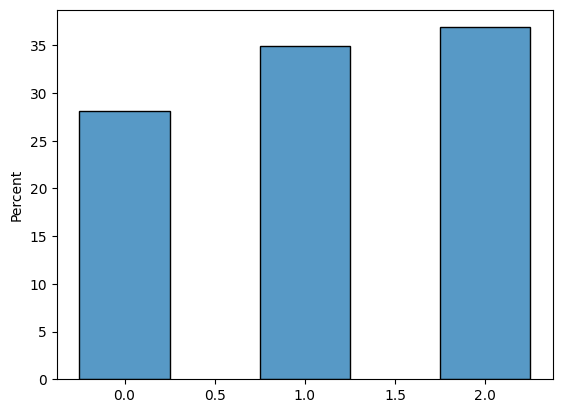

In [18]:
import seaborn as sns

# We analyze the distribution of the actions taken during training
actions_arr = rb.actions

sns.histplot(data=actions_arr.flatten(), stat='percent',
             discrete=True, element='bars', shrink=0.5)